# CSE 252B: Computer Vision II, Winter 2018 – Assignment 2
### Instructor: Ben Ochoa
### Due: Wednesday, February 7, 2018, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains both math and programming problems.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX. Remember to show work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* This notebook contains skeleton code, which should not be modified (This is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. Ask the instructor if in doubt.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

## Problem 1 (Programing):  Linear estimation of the camera projection matrix (15 points)
  Download input data from the course website.  The file
  hw2_points3D.txt contains the coordinates of 50 scene points
  in 3D (each line of the file gives the $\tilde{X}_i$, $\tilde{Y}_i$,
  and $\tilde{Z}_i$ inhomogeneous coordinates of a point).  The file
  hw2_points2D.txt contains the coordinates of the 50
  corresponding image points in 2D (each line of the file gives the
  $\tilde{x}_i$ and $\tilde{y}_i$ inhomogeneous coordinates of a
  point).  The scene points have been randomly generated and projected
  to image points under a camera projection matrix (i.e., $\boldsymbol{x}_i
  = \boldsymbol{P} \boldsymbol{X}_i$), then noise has been added to the image point
  coordinates.

  Estimate the camera projection matrix $\boldsymbol{P}_\text{DLT}$ using the
  direct linear transformation (DLT) algorithm (with data
  normalization).  You must express $\boldsymbol{x}_i = \boldsymbol{P} \boldsymbol{X}_i$
  as $[\boldsymbol{x}_i]^\perp \boldsymbol{P} \boldsymbol{X}_i = \boldsymbol{0}$ (not
  $\boldsymbol{x}_i \times \boldsymbol{P} \boldsymbol{X}_i = \boldsymbol{0}$), where
  $[\boldsymbol{x}_i]^\perp \boldsymbol{x}_i = \boldsymbol{0}$, when forming the
  solution. Return
  $\boldsymbol{P}_\text{DLT}$, scaled such that
  $||\boldsymbol{P}_\text{DLT}||_\text{Fro} = 1$

x is (2, 50)
X is (3, 50)
P_DLT =
[[  6.04350846e-03  -4.84282446e-03   8.82395315e-03   8.40441373e-01]
 [  9.09666810e-03  -2.30374203e-03  -6.18060233e-03   5.41657305e-01]
 [  5.00625470e-06   4.47558354e-06   2.55223773e-06   1.25160752e-03]]
||P_DLT||=1.000000


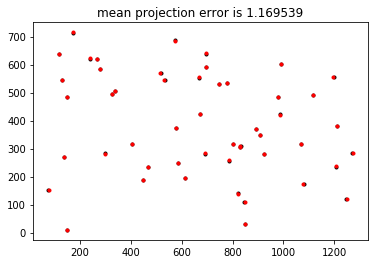

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x=np.loadtxt('hw2_points2D.txt').T
X=np.loadtxt('hw2_points3D.txt').T
print('x is', x.shape)
print('X is', X.shape)

def toHomo(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))
def fromHomo(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1,:]/x[-1,:]
def Normalize(x):
    mu = np.mean(x,axis=1)
    var = np.sum(np.var(x,axis=1))
    s = np.sqrt((x.shape[0]+0.0)/var)
    H = np.zeros((x.shape[0]+1,x.shape[0]+1))
    for i in range(x.shape[0]):
        H[i,i] = s
        H[i,x.shape[0]] = -mu[i]*s
    H[x.shape[0],x.shape[0]] = 1
    x_homo = toHomo(x)
    x_normalized_homo = np.dot(H,x_homo)
    return (x_normalized_homo,H)

def computeP_DLT(x,X):
    # inputs:
    # x 2D points
    # X 3D points
    # output:
    # P_DLT the (3x4) DLT estimate of the camera projection matrix
    
    """your code here"""
    #data normalization
    x_normalized_homo,T = Normalize(x)
    X_normalized_homo,U = Normalize(X)
    
    A = np.zeros((1,12))
    e = np.zeros((3,1))
    e[0,0] = 1
    for i in range(X.shape[1]):
        pts_2 = np.array([x_normalized_homo[:,i]]).T
        pts_3 = np.array([X_normalized_homo[:,i]]).T
        v = pts_2 + np.sign(pts_2[0,0])*np.linalg.norm(pts_2,2)*e
        H_v = np.identity(3) - 2.0*np.dot(v,v.T)/np.dot(v.T,v)
        x_perp = H_v[1:,:]
        A = np.vstack((A,np.kron(x_perp,pts_3.T)))
    U_svd, s, V = np.linalg.svd(A[1:,:], full_matrices=False)
    P = np.array([V[11,0:4],V[11,4:8],V[11,8:]])
    P = P/(P[2,3]+0.0)
    P = np.dot(np.linalg.inv(T),P)
    P = np.dot(P,U)
    return P/np.sqrt(np.sum(P**2))

def proj(P,X):
    # projects 3d points X to 2d using projection matrix P
    return fromHomo(np.matmul(P,toHomo(X)))
    
def rmse(x,y):
    # calculates the root mean square error (RMSE)
    # used to measure reprojection error
    return np.mean(np.sqrt(np.sum((x-y)**2,0)))
    
def displayResults(P, x, X, title):
    print (title+' =')
    print (P)
    print ('||%s||=%f'%(title, np.sqrt(np.sum(P**2)) ))

    x_proj = proj(P,X)
    plt.plot(x[0,:], x[1,:],'.k')
    plt.plot(x_proj[0,:], x_proj[1,:],'.r')
    for i in range(x.shape[1]):
        plt.plot([x[0,i], x_proj[0,i]], [x[1,i], x_proj[1,i]], '-r')
    
    plt.title('mean projection error is %f'%rmse(x,x_proj))
    plt.show()

P_DLT = computeP_DLT(x,X)
displayResults(P_DLT, x, X, 'P_DLT')

## Problem 2 (Programing):  Nonlinear estimation of the camera projection matrix (30 points)
  Use $\boldsymbol{P}_\text{DLT}$ as an initial estimate to an iterative
  estimation method, specifically the Levenberg-Marquardt algorithm,
  to determine the Maximum Likelihood estimate of the camera
  projection matrix that minimizes the projection error.  You must
  parameterize the camera projection matrix as a parameterization of
  the homogeneous vector $\boldsymbol{p} = vec{(\boldsymbol{P}^\top)}$.  It is
  highly recommended to implement a parameterization of homogeneous
  vector method where the homogeneous vector is of arbitrary length,
  as this will be used in following assignments.
  Return $\boldsymbol{P}_\text{LM}$, scaled such that $||\boldsymbol{P}_\text{LM}||_\text{Fro} = 1$.
  You may need to change the max itterations or implement another stoping criteria.

iter 1 mean reprojection error 1.155751
iter 1 cost: 84.104680
iter 2 mean reprojection error 1.155502
iter 2 cost: 82.803231
iter 3 mean reprojection error 1.155502
iter 3 cost: 82.802734
iter 4 mean reprojection error 1.155502
iter 4 cost: 82.802734
iter 5 mean reprojection error 1.155502
iter 5 cost: 82.802734
iter 6 mean reprojection error 1.155502
iter 6 cost: 82.802734
iter 7 mean reprojection error 1.155502
iter 7 cost: 82.802734
iter 8 mean reprojection error 1.155502
iter 8 cost: 82.802734
iter 9 mean reprojection error 1.155502
iter 9 cost: 82.802734
iter 10 mean reprojection error 1.155502
iter 10 cost: 82.802734
P_LM =
[[  6.10553106e-03  -4.65741551e-03   8.76290441e-03   8.43874212e-01]
 [  8.99309840e-03  -2.25732484e-03  -6.08550802e-03   5.36298428e-01]
 [  5.03594566e-06   4.49298303e-06   2.55959413e-06   1.24443310e-03]]
||P_LM||=1.000000


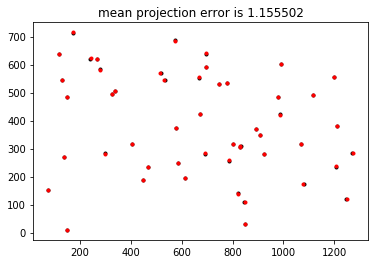

In [3]:
def sinc(x):
    if x == 0:
        return 1
    else:
        return np.sin(x) / x
    
def sinc_prime(x):
    if x == 0:
        return 0
    else:
        return np.cos(x)/x-np.sin(x)/(x**2)
    
def Parameterization(v):
    a = v[0]
    b = v[1:]
    v_i = 2.0/sinc(np.arccos(a))*b
    
    if np.linalg.norm(v_i)>np.pi:
        v_i = (1-2.0*np.pi/np.linalg.norm(v_i)*np.ceil((np.linalg.norm(v_i)-np.pi)/(2.0*np.pi)))*v_i
    return v_i.reshape(11,1)

def Deparameterization(v):
    if np.linalg.norm(v)>np.pi:
        v = (1-2.0*np.pi/np.linalg.norm(v)*np.ceil((np.linalg.norm(v)-np.pi)/(2.0*np.pi)))*v
    a = np.cos(np.linalg.norm(v)/2.0)
    b = sinc(np.linalg.norm(v)/2.0)/2.0*v
    return np.vstack((a,b))

def Parameterization_prime(v):
    ppprime = np.zeros((v.shape[0]+1,v.shape[0]))
    b = sinc(np.linalg.norm(v)/2.0)/2.0*v
    if np.linalg.norm(v) == 0:
        ppprime[1:,:] = 0.5*np.identity(v.shape[0])
    else:
        ppprime[0,:] = -1.0/2*b.T
        ppprime[1:,:] = sinc(np.linalg.norm(v)/2.0)/2.0*np.identity(v.shape[0])+1.0/(4*np.linalg.norm(v))*sinc_prime(np.linalg.norm(v)/2.0)*np.dot(v,v.T)
    
    return ppprime

def Jacobian(p,x,X):
    X = toHomo(np.reshape(X,(3,1)))
    w = np.dot(np.reshape(p[8:,0],(1,4)),X)
    p = Parameterization(p)
    p1 = 1.0/w*np.array([[X[0],X[1],X[2],X[3],0,0,0,0,-x[0]*X[0],-x[0]*X[1],-x[0]*X[2],-x[0]*X[3]],[0,0,0,0,X[0],X[1],X[2],X[3],-x[1]*X[0],-x[1]*X[1],-x[1]*X[2],-x[1]*X[3]]])
    p2 = Parameterization_prime(p)
    return np.dot(p1,p2)

def project_error(x,P,X):
    result = x - proj(P,X)
    return np.reshape(result,(2*X.shape[1],1),order = 'F')

def LMstep(P, x, X, l, v):
    # inputs:
    # P current estimate of P
    # x 2D points
    # X 3D points
    # l LM lambda parameter
    # v LM change of lambda parameter
    # output:
    # P updated by a single LM step
    # l accepted lambda parameter
    
    """your code here"""
    x,T = Normalize(x)
    X,M = Normalize(X)
    x = fromHomo(x)
    X = fromHomo(X)
    s = T[0,0]**2
    P = np.dot(T,P)
    P = np.dot(P,np.linalg.inv(M))
    P = P/np.sqrt(np.sum(P**2))
    
    p = np.zeros((12,1))
    p[:4,0] = P[0,:]
    p[4:8,0] = P[1,:]
    p[8:,0] = P[2,:]
    J = np.zeros((2*X.shape[1],11))
    epsil = project_error(x,P,X)
    sigma = s*np.identity(2*X.shape[1])
    flag = True
    iter_num = 0

    for i in range(X.shape[1]):
        J[0+i*2:2+i*2,:] = Jacobian(p,x[:,i],X[:,i])
    U = np.dot(np.dot(J.T,np.linalg.inv(sigma)),J)
    epsil_a = np.dot(np.dot(J.T,np.linalg.inv(sigma)),epsil)
    while(flag):
        if iter_num>20:
            flag = False
        U_0 = U + l*np.identity(11)
        delta = np.dot(np.linalg.inv(U_0),epsil_a)
        p_p = Parameterization(p)
        p_0 = Deparameterization(p_p + delta)
        P_0 = np.zeros((3,4))
        P_0[0,:] = p_0[:4,0]
        P_0[1,:] = p_0[4:8,0]
        P_0[2,:] = p_0[8:,0]
        P_0 = P_0/(P_0[2,3]+0.0)
        epsil_0 = project_error(x,P_0,X)
        error1 = np.dot(np.dot(epsil_0.T,np.linalg.inv(sigma)),epsil_0)
        error2 = np.dot(np.dot(epsil.T,np.linalg.inv(sigma)),epsil)
        if error1<error2:
            P = P_0
            l = 0.1*l
            flag = False
        else:
            l = 10*l
            iter_num = iter_num + 1
    
    P = np.dot(np.linalg.inv(T),P)
    P = np.dot(P,M)
    return P/np.sqrt(np.sum(P**2)), l, error2

# use P_DLT as an initalization for LM
P_LM = P_DLT.copy()

# LM hyperparameters
l=.001
v=10
max_iters=10

# LM optimization loop
for i in range(max_iters):
    P_LM, l, cost = LMstep(P_LM, x, X, l, v)
    print ('iter %d mean reprojection error %f'%(i+1, rmse(x,proj(P_LM,X))))
    print ('iter %d cost: %f'%(i+1, cost))
    
displayResults(P_LM, x, X, 'P_LM')